In [1]:
from src.extract_data import load_data, process_data
from src.utils import get_test_set
import pandas as pd
from src.constants import FILE_PATH
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import numpy as np 
import seaborn as sns
set_matplotlib_formats('svg')
import tensorflow as tf
import IPython
import IPython.display

from src.utils import build_time_series

/tmp/ipykernel_2018/829871368.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
2021-08-29 11:23:59.875488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-29 11:23:59.875511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_test(x_test, y_test, model = None):
    y_test = y_test.reshape(y_test.shape[0], -1)
    fix, ax = plt.subplots(y_test.shape[1] , 1, figsize=(10,7))
    
    if y_test.shape[1] == 1:
        historical_index = [x for x in range(x_test.shape[0])]
        pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

        ax.plot(historical_index, x_test[:, 0], marker='.', label='Input')
        ax.scatter(pred_index, y_test[:, 0], edgecolors='k', label='Labels', c='#2ca02c', s=32)

        if model is not None:
            preds = model(np.expand_dims(x_test, axis=0))[0]
            ax.scatter(pred_index, preds[:, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            
    else:
        for i in range(y_test.shape[1]):
            historical_index = [x for x in range(x_test.shape[0])]
            pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

            ax[i].plot(historical_index, x_test[:, i], marker='.', label='Input')
            ax[i].scatter(pred_index, y_test[:, i], edgecolors='k', label='Labels', c='#2ca02c', s=32)

            if model is not None:
                preds = model(np.expand_dims(x_test, axis=0))[0]
                ax[i].scatter(pred_index, preds[:, i],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
    plt.legend()

In [3]:
FORECAST_SIZE = 5
WINDOW_SIZE = FORECAST_SIZE * 10
NUM_FEATURES = 1

In [4]:
df = load_data(FILE_PATH)
df = process_data(df, use_covariates=False)
#df = df.drop(['day_of_month', 'month'], axis=1)



In [5]:
df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,18680,1799
2019-03-02,12341,1049
2019-03-03,10839,969
2019-03-04,18502,2228
2019-03-05,18373,1767


In [6]:
n = len(df)
train_df = df[0:int(n*0.7)].astype(float)
val_df = df[int(n*0.7):int(n*0.9)].astype(float)
test_df = df[int(n*0.9):].astype(float)

In [7]:
def normalize(data):
    dic = {}
    for col in ['nbr_travels', 'nbr_late_trains']:
        data_mean = data[col].mean()
        data_std = data[col].std()
        dic[col] = [data_mean, data_std]
    return dic

dic = normalize(train_df)

In [8]:
train_df['nbr_travels'] = (train_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
train_df['nbr_late_trains'] = (train_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

val_df['nbr_travels'] = (val_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
val_df['nbr_late_trains'] = (val_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

test_df['nbr_travels'] = (test_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
test_df['nbr_late_trains'] = (test_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

In [9]:
#train_df = train_df.drop('nbr_late_trains', axis=1)
#val_df = val_df.drop('nbr_late_trains', axis=1)
#test_df = test_df.drop('nbr_late_trains', axis=1)


train_df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,1.256222,0.793774
2019-03-02,-0.239490,-0.356145
2019-03-03,-0.593893,-0.478803
2019-03-04,1.214223,1.451528
2019-03-05,1.183785,0.744711


In [10]:
train_x, train_y = build_time_series(train_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
val_x, val_y = build_time_series(val_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
test_x, test_y = build_time_series(test_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)

train_y = train_y[:, :, 0]
val_y = val_y[:, :, 0]
test_y = test_y[:, :, 0]

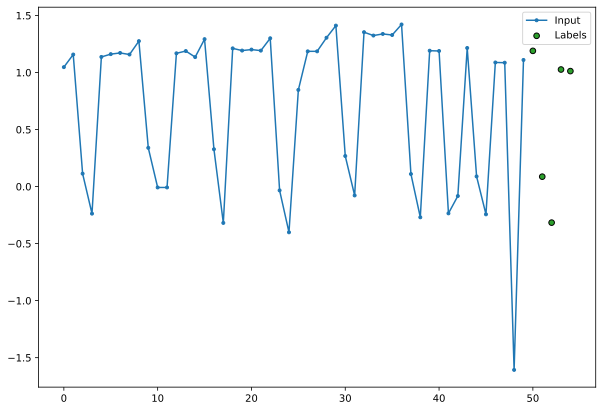

In [11]:
plot_test(test_x[0], test_y[0])

In [12]:
def compile_and_fit(model, max_epochs, train_x, train_y, val_x, val_y, patience=40):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(train_x, train_y, epochs=max_epochs,
                      validation_data=(val_x, val_y),
                      callbacks=[early_stopping])
    return history

In [13]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(128, return_sequences=False),

    tf.keras.layers.Dense(FORECAST_SIZE*NUM_FEATURES),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([FORECAST_SIZE, NUM_FEATURES])
])

history = compile_and_fit(
    multi_lstm_model,
    500,
    train_x,
    train_y,
    val_x,
    val_y)

#IPython.display.clear_output()

2021-08-29 11:24:12.106469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-29 11:24:12.106489: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-29 11:24:12.106504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8e05c53b2018): /proc/driver/nvidia/version does not exist
2021-08-29 11:24:12.157128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
19/19 [==============================] - 3s 55ms/step - loss: 0.6942 - mean_absolute_error: 0.7420 - val_loss: 0.5492 - val_mean_absolute_error: 0.6902
Epoch 2/500
19/19 [==============================] - 1s 39ms/step - loss: 0.5291 - mean_absolute_error: 0.6329 - val_loss: 0.4339 - val_mean_absolute_error: 0.6095
Epoch 3/500
19/19 [==============================] - 1s 34ms/step - loss: 0.4552 - mean_absolute_error: 0.5764 - val_loss: 0.3461 - val_mean_absolute_error: 0.5133
Epoch 4/500
19/19 [==============================] - 1s 32ms/step - loss: 0.3705 - mean_absolute_error: 0.5085 - val_loss: 0.2859 - val_mean_absolute_error: 0.4289
Epoch 5/500
19/19 [==============================] - 1s 31ms/step - loss: 0.3265 - mean_absolute_error: 0.4541 - val_loss: 0.2854 - val_mean_absolute_error: 0.4232
Epoch 6/500
19/19 [==============================] - 1s 33ms/step - loss: 0.2971 - mean_absolute_error: 0.4258 - val_loss: 0.2340 - val_mean_absolute_error: 0.3771
Epoch 7/500
19/1

Epoch 51/500
19/19 [==============================] - 1s 36ms/step - loss: 0.0768 - mean_absolute_error: 0.1621 - val_loss: 0.1278 - val_mean_absolute_error: 0.2332
Epoch 52/500
19/19 [==============================] - 1s 36ms/step - loss: 0.0778 - mean_absolute_error: 0.1724 - val_loss: 0.1243 - val_mean_absolute_error: 0.2322
Epoch 53/500
19/19 [==============================] - 1s 35ms/step - loss: 0.0770 - mean_absolute_error: 0.1683 - val_loss: 0.1343 - val_mean_absolute_error: 0.2402
Epoch 54/500
19/19 [==============================] - 1s 37ms/step - loss: 0.0777 - mean_absolute_error: 0.1653 - val_loss: 0.1283 - val_mean_absolute_error: 0.2323
Epoch 55/500
19/19 [==============================] - 1s 39ms/step - loss: 0.0764 - mean_absolute_error: 0.1683 - val_loss: 0.1142 - val_mean_absolute_error: 0.2124
Epoch 56/500
19/19 [==============================] - 1s 36ms/step - loss: 0.0764 - mean_absolute_error: 0.1658 - val_loss: 0.1447 - val_mean_absolute_error: 0.2545
Epoch 57/5

MAPE : 54.847775 %


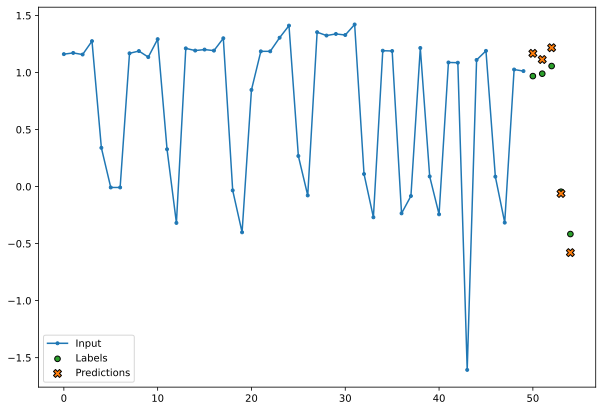

In [20]:
plot_test(test_x[5], test_y[5], model=multi_lstm_model)
preds = multi_lstm_model(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


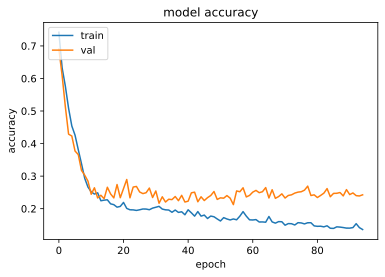

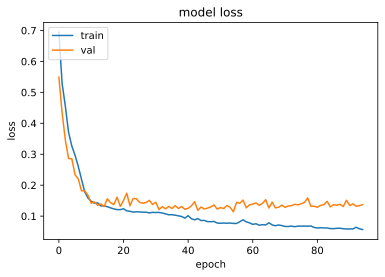

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

mape = mean_absolute_percentage_error(preds.numpy().reshape(37,5), test_y)
mse = mean_squared_error(preds.numpy().reshape(37,5), test_y)
mae = mean_absolute_error(preds.numpy().reshape(37,5), test_y)

print('MAPE :', round(mape *100,2) ,'%')
print('MSE :', round(mse,2))
print('MAE :', round(mae,2))

MAPE : 43.08 %
MSE : 0.15
MAE : 0.2


In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(FORECAST_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([FORECAST_SIZE, NUM_FEATURES])
])

history = compile_and_fit(
    multi_conv_model,
    200,
    train_x,
    train_y,
    val_x,
    val_y)

In [ ]:
plot_test(test_x[0], test_y[0], model=multi_conv_model)
preds = multi_conv_model(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()